# Understanding Regularized Spectral Clustering via Graph Conductance 

This notebook reproduces the results of Understanding Regularized Spectral Clustering via Graph Conductance (Zhang et al, 2018). In addition to this, more experiments are run for understanding the effects of regularisation on clustering with $k > 2$ and the importance of the regularisation parameter $\tau$.

In [182]:
import time
import os
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

from scipy.cluster.vq import whiten, kmeans
from numpy import linalg as LA
from networkx.algorithms.cuts import conductance
from scipy.sparse.linalg import eigsh

%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})

## Reproducing the results

In [170]:
def eig_laplacian(A, k=2):
    n = np.shape(A)[0]
    D = np.diag(1 / np.sqrt(np.ravel(A.sum(axis=0))))
    L = np.identity(n) - D.dot(A).dot(D)
    return eigsh(L, k, which='SM')
    
def spectral_clust(A, k=2):
    n = np.shape(A)[0]
    V, Z = eig_laplacian(A, k)
    
    rows_norm = np.linalg.norm(Z, axis=1, ord=2)
    Y = (Z.T / rows_norm).T
    centroids, distortion = kmeans(Y, k)
    
    y_hat = np.zeros(n, dtype=int)
    for i in range(n):
        dists = np.array([np.linalg.norm(Y[i] - centroids[c]) for c in range(k)])
        y_hat[i] = np.argmin(dists)
    return y_hat

def spectral_clust_chauduri(A, tau, k=2):
    n = np.shape(A)[0]
    At = A + tau / n
    D = np.diag(1 / np.sqrt(np.ravel(At.sum(axis=0))))
    L = np.identity(n) - D.dot(A).dot(D)
    V, Z = eigsh(L, k, which='SM')
    
    rows_norm = np.linalg.norm(Z, axis=1, ord=2)
    Y = (Z.T / rows_norm).T
    centroids, distortion = kmeans(Y, k)
    
    y_hat = np.zeros(n, dtype=int)
    for i in range(n):
        dists = np.array([np.linalg.norm(Y[i] - centroids[c]) for c in range(k)])
        y_hat[i] = np.argmin(dists)
    return y_hat

In [189]:
# Load the data
def read_graph(filepath, source_graph=None):
    # Use the largest connected component from the graph
    if source_graph is None:
        graph = nx.read_edgelist(filepath, nodetype=int).to_undirected()
    else:
        graph = source_graph
    graph = max(nx.connected_component_subgraphs(graph), key=len)
    
    # Split the graph edges into train and test
    random_edges = list(graph.edges())
    np.random.shuffle(random_edges)
    train_edges = random_edges[:graph.number_of_edges()//2]
    test_edges = random_edges[graph.number_of_edges()//2:]
    
    # Create the training graph
    train_graph = nx.Graph()
    train_graph.add_edges_from(train_edges)
    train_graph = max(nx.connected_component_subgraphs(train_graph), key=len)
    
    # Create the test graph
    test_graph = nx.Graph()
    test_graph.add_nodes_from(train_graph.nodes())
    test_graph.add_edges_from(test_edges)
    
    return train_graph, test_graph

def generate_dangling_random_graph(partitions=2):
    graph = nx.gaussian_random_partition_graph(partitions * 100, 100, 10, 0.4, 0.05)
    graph.add_path([1, 300, 1234, 500, 280, 267, 221, 267, 221])
    graph.add_path([2, 301, 1231, 501, 281, 261, 222, 261, 222])
    graph.add_path([3, 3012, 12312, 5012, 2812, 2612, 2222, 5021, 3021])
    return graph

In [190]:
graph_map = {
    1: './dataset/email-Eu-core.txt',
    2: './dataset/0.edges',
    3: './dataset/gnutella08.txt',
    4: './dataset/as20000102.txt',
    5: './dataset/as19991212.txt',
    6: './dataset/ca-GrQc.txt',
    7: './dataset/as19991221.txt',
    8: './dataset/twitter',
    9: './dataset/tvshow.txt',
    10: './dataset/politicians.txt',
    11: './dataset/as19991230.txt',
    12: './dataset/as19971111.txt',
    13: './dataset/gnutella09.txt',
    14: './dataset/gnutella06.txt',
    15: './dataset/government.txt',
    16: './dataset/wiki-Vote.txt',
}

In [191]:
# Compute the size of the smallest partition
def get_min_part_size(labels):
    return min(np.sum(labels), np.size(labels) - np.sum(labels))

def get_avg_min_part_size(map_entry):
    van_part, reg_part = [], []
    for seed in range(0, 1):
        np.random.seed(seed)
        train, _ = read_graph(graph_map[map_entry])
        
        N = train.number_of_nodes()
        S = nx.to_numpy_matrix(train)
        tao = train.number_of_edges() * 2 / N
        SR = S + tao / N
        
        van_labels = spectral_clust(S)
        reg_labels = spectral_clust(SR)
        
        van_part.append(get_min_part_size(van_labels))
        reg_part.append(get_min_part_size(reg_labels))
    
    return np.mean(van_part), np.mean(reg_part), N

def graphs_part_sizes():
    van_sizes, reg_sizes, graph_sizes = [], [], []
    for graph_key in graph_map:
        print('Processing ' + graph_map[graph_key])
        van, reg, size = get_avg_min_part_size(graph_key)
        van_sizes.append(van)
        reg_sizes.append(reg)
        graph_sizes.append(size)
    return van_sizes, reg_sizes, graph_sizes

In [192]:
van_sizes, reg_sizes, sizes = graphs_part_sizes()

Processing ./dataset/email-Eu-core.txt
Processing ./dataset/0.edges
Processing ./dataset/gnutella08.txt
Processing ./dataset/as20000102.txt
Processing ./dataset/as19991212.txt
Processing ./dataset/ca-GrQc.txt
Processing ./dataset/as19991221.txt
Processing ./dataset/twitter
Processing ./dataset/tvshow.txt
Processing ./dataset/politicians.txt
Processing ./dataset/as19991230.txt
Processing ./dataset/as19971111.txt
Processing ./dataset/gnutella09.txt
Processing ./dataset/gnutella06.txt
Processing ./dataset/government.txt
Processing ./dataset/wiki-Vote.txt


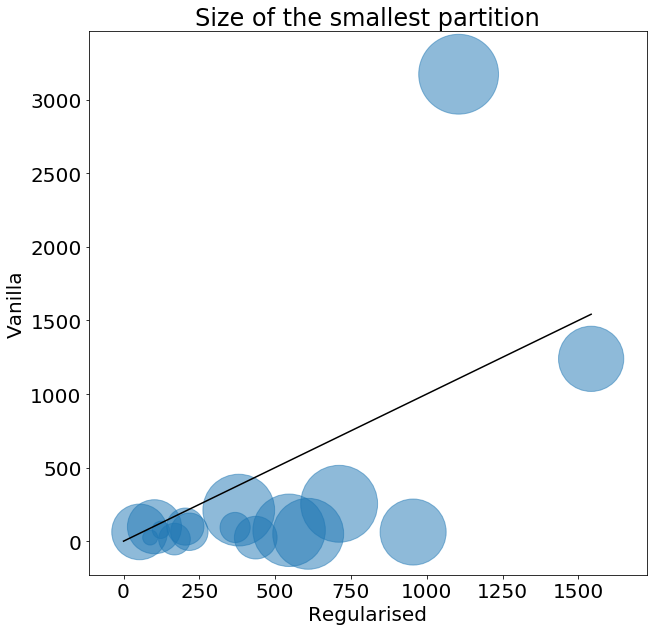

In [194]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
maxim = max(np.max(van_sizes), np.max(reg_sizes))
ax.plot([0, np.max(reg_sizes)], [0, np.max(reg_sizes)], color='black')
ax.set_xlabel('Regularised')
ax.set_ylabel('Vanilla')
ax.set_title('Size of the smallest partition')
ax.scatter(reg_sizes, van_sizes, sizes, alpha=0.5)

In [158]:
def get_conductance(map_entry):
    van_cond_train, van_cond_test = [], []
    reg_cond_train, reg_cond_test = [], []
    for seed in range(0, 1):
        np.random.seed(seed)
        train, test = read_graph(graph_map[map_entry])
        
        N = train.number_of_nodes()
        S = nx.to_numpy_matrix(train)
        tao = train.number_of_edges() * 2 / N
        SR = S + tao / N
        
        van_labels = spectral_clust(S)
        reg_labels = spectral_clust(SR)
        
        nodes = np.array(list(train.nodes()))
        van_cond_train.append(conductance(train, nodes[van_labels == 1]))
        van_cond_test.append(conductance(test, nodes[van_labels == 1]))
        reg_cond_train.append(conductance(train, nodes[reg_labels == 1]))
        reg_cond_test.append(conductance(test, nodes[reg_labels == 1]))
    
    return np.mean(van_cond_train), np.mean(reg_cond_train), np.mean(van_cond_test), np.mean(reg_cond_test), N
    
def graphs_conductances():
    van_train, reg_train, van_test, reg_test, sizes = [], [], [], [], []
    for graph_key in graph_map:
        print('Processing graph ' + graph_map[graph_key])
        vt, rt, vtes, rtes, s = get_conductance(graph_key)
        van_train.append(vt)
        reg_train.append(rt)
        van_test.append(vtes)
        reg_test.append(rtes)
        sizes.append(s)
        
    return van_train, reg_train, van_test, reg_test, sizes

In [159]:
van_train, reg_train, van_test, reg_test, sizes = graphs_conductances()

Processing graph ./dataset/email-Eu-core.txt
Processing graph ./dataset/0.edges
Processing graph ./dataset/gnutella08.txt
Processing graph ./dataset/as20000102.txt
Processing graph ./dataset/as19991212.txt
Processing graph ./dataset/ca-GrQc.txt
Processing graph ./dataset/as19991221.txt
Processing graph ./dataset/twitter
Processing graph ./dataset/tvshow.txt
Processing graph ./dataset/politicians.txt
Processing graph ./dataset/as19991230.txt
Processing graph ./dataset/as19971111.txt
Processing graph ./dataset/gnutella09.txt
Processing graph ./dataset/gnutella06.txt
Processing graph ./dataset/government.txt
Processing graph ./dataset/wiki-Vote.txt


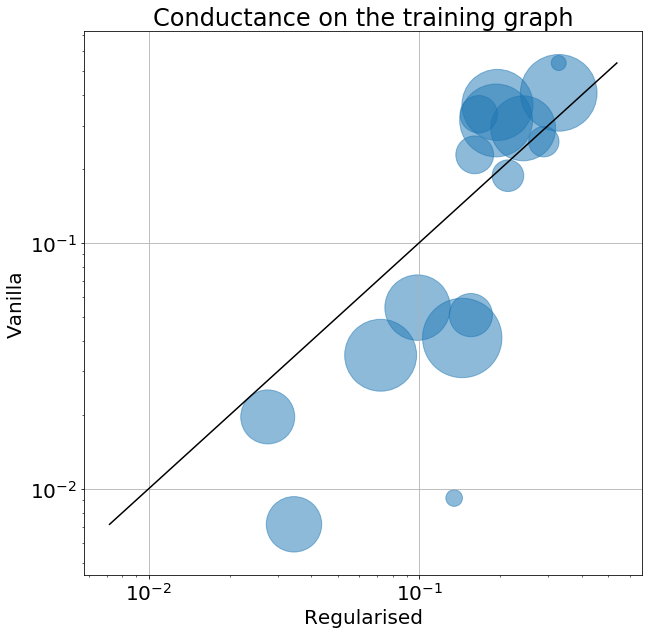

In [184]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10));
minim = min(np.min(van_train), np.min(reg_train))
maxim = max(np.max(van_train), np.max(reg_train))
ax.plot([minim, maxim], [minim, maxim], color='black')
ax.grid(True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Regularised')
ax.set_ylabel('Vanilla')
ax.set_title('Conductance on the training graph')
ax.scatter(reg_train, van_train, sizes, alpha=0.5)

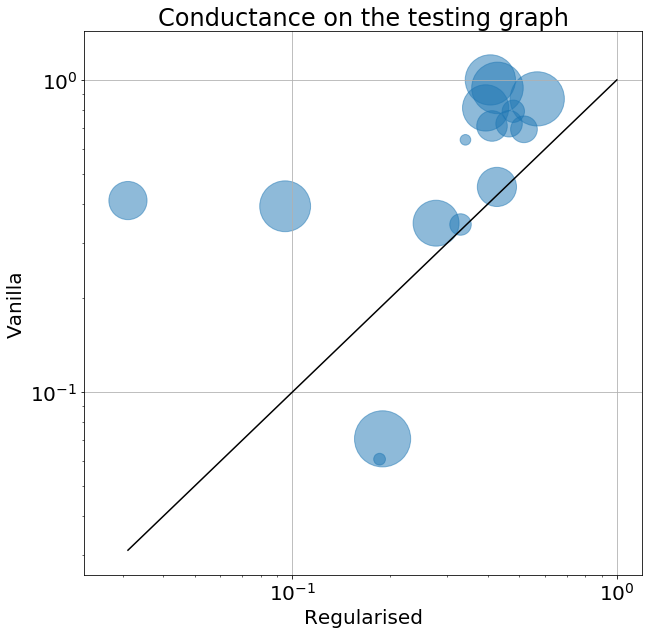

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10));
minim = min(np.min(van_test), np.min(reg_test))
maxim = max(np.max(van_test), np.max(reg_test))
ax.plot([minim, maxim], [minim, maxim], color='black')
ax.grid(True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Regularised')
ax.set_ylabel('Vanilla')
ax.set_title('Conductance on the testing graph')
ax.scatter(reg_test, van_test, np.array(sizes) * 0.5, alpha=0.5, )

In [165]:
def benchmark(fct, runs=5): 
    times = []
    for run in range(runs):
        start = time.time()
        fct()
        end = time.time()
        times.append(end-start)
    return np.mean(times)

def graphs_benchmark():
    vant, regt, sizes = [], [], []
    for graph_key in graph_map:
        print('Processing graph ' + graph_map[graph_key])
       
        train, _ = read_graph(graph_map[graph_key])
        N = train.number_of_nodes()
        S = nx.to_numpy_matrix(train)
        tao = 2 * train.number_of_edges() / N
        SR = S + tao / N

        vant.append(benchmark(lambda: eig_laplacian(S)))
        regt.append(benchmark(lambda: eig_laplacian(SR)))
        sizes.append(train.number_of_nodes())

    return vant, regt, sizes

In [166]:
van_times, reg_time, sizes = graphs_benchmark()

Processing graph ./dataset/email-Eu-core.txt
Processing graph ./dataset/0.edges
Processing graph ./dataset/gnutella08.txt
Processing graph ./dataset/as20000102.txt
Processing graph ./dataset/as19991212.txt
Processing graph ./dataset/ca-GrQc.txt
Processing graph ./dataset/as19991221.txt
Processing graph ./dataset/twitter
Processing graph ./dataset/tvshow.txt
Processing graph ./dataset/politicians.txt
Processing graph ./dataset/as19991230.txt
Processing graph ./dataset/as19971111.txt
Processing graph ./dataset/gnutella09.txt
Processing graph ./dataset/gnutella06.txt
Processing graph ./dataset/government.txt
Processing graph ./dataset/wiki-Vote.txt


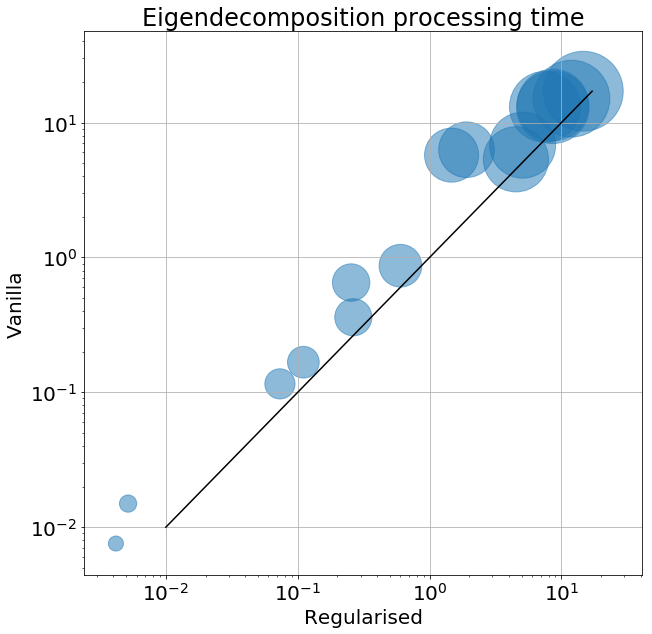

In [196]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10));
maxim = max(np.max(van_times), np.max(reg_time))
ax.plot([0.01, maxim], [0.01, maxim], color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)
ax.set_xlabel('Regularised')
ax.set_ylabel('Vanilla')
ax.set_title('Eigendecomposition processing time')
ax.scatter(reg_time, van_times, sizes, alpha=0.5)

## Analyse an individual graph in detail

In [129]:
np.random.seed(8)
# train_graph, test_graph = read_graph(graph_map[4])
# train_graph, test_graph = read_graph('', nx.karate_club_graph())
# train_graph, test_graph = read_graph('', nx.davis_southern_women_graph())
# train_graph, test_graph = read_graph('', nx.florentine_families_graph())
train_graph, test_graph = read_graph('', generate_dangling_random_graph())
# train_graph, test_graph = read_graph('', nx.read_gml('./dataset/polblogs.gml').to_undirected())

In [130]:
# Compare the eigenvectors of the markov matrix of the vanilla and regularised graphs
S = nx.to_numpy_matrix(train_graph)

# Tao is initialised with the average degree of the graph
N = train_graph.number_of_nodes()
tao = 2.25
SR = S + tao / N

val_van, vec_van = eig_laplacian(S, 100)
val_reg, vec_reg = eig_laplacian(SR, 100)

Text(0,0.5,'Magnitude')

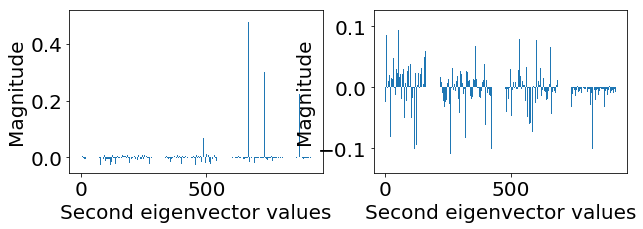

In [193]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3));
ax1.bar(np.arange(len(vec_van[:, 1])), vec_van[:, 1])
ax1.set_xlabel('Second eigenvector values')
ax1.set_ylabel('Magnitude')
ax2.bar(np.arange(len(vec_reg[:, 1])), vec_reg[:, 1])
ax2.set_xlabel('Second eigenvector values')
ax2.set_ylabel('Magnitude')

In [132]:
# Compute the number of nodes in the smallest partition set.
van_labels = spectral_clust(S)
reg_labels = spectral_clust(SR)

In [133]:
# Compute the size of the minimum partition
van_min_size = min(np.sum(van_labels), np.sum(1 - van_labels))
reg_min_size = min(np.sum(reg_labels), np.sum(1 - reg_labels))
print("Vanilla smallest partition size: {}".format(van_min_size))
print("CoreCut smallest partition size: {}".format(reg_min_size))

Vanilla smallest partition size: 8
CoreCut smallest partition size: 100


In [134]:
# Compute the conductange of the smallest set
nodes = np.array(list(train_graph.nodes()))
van_nodes_with_label = nodes[van_labels == 1]
reg_nodes_with_label = nodes[reg_labels == 1]

print("Vanilla conductance on train: {}".format(conductance(train_graph, van_nodes_with_label)))
print("CoreCut conductance on train: {}".format(conductance(train_graph, reg_nodes_with_label)))
print("Vanilla conductance on test: {}".format(conductance(test_graph, van_nodes_with_label)))
print("CoreCut conductance on test: {}".format(conductance(test_graph, reg_nodes_with_label)))

Vanilla conductance on train: 0.06666666666666667
CoreCut conductance on train: 0.06474820143884892
Vanilla conductance on test: 0.14285714285714285
CoreCut conductance on test: 0.05986903648269411


In [135]:
def node_colors(labels):
    colors = np.empty_like(labels, dtype=object)
    colors[labels == 1] = 'orange'
    colors[labels == 0] = 'cornflowerblue'
    return colors

def draw_bipartite_graph(graph, nodelist, labels):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20));
    nx.draw_networkx(graph, ax=ax, with_labels=False, nodelist=nodelist, 
                     node_color=node_colors(labels), node_size=50)

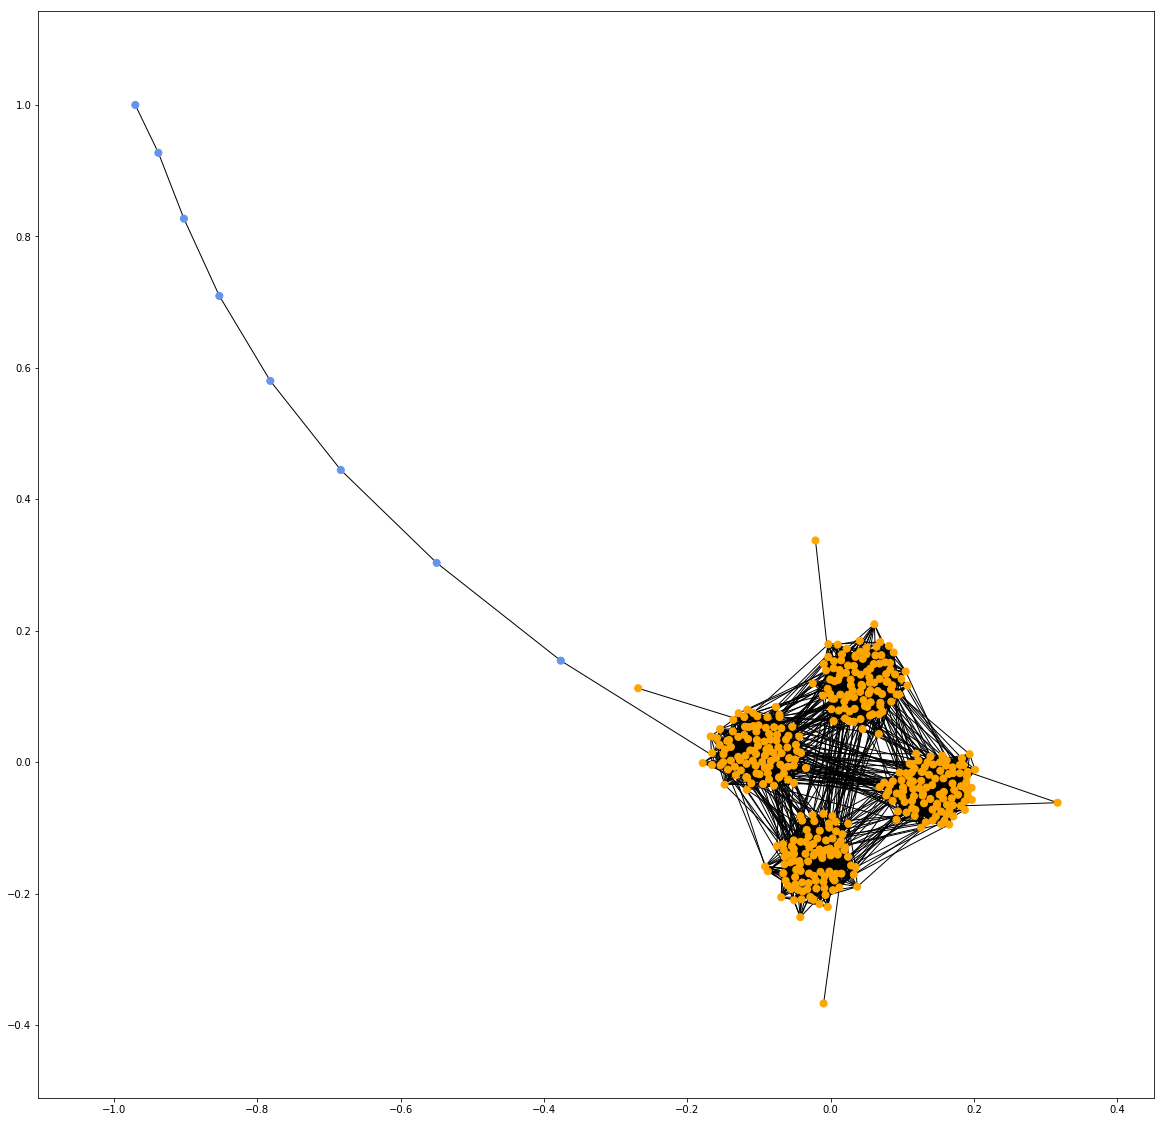

In [136]:
draw_bipartite_graph(train_graph, list(train_graph.nodes()), van_labels)

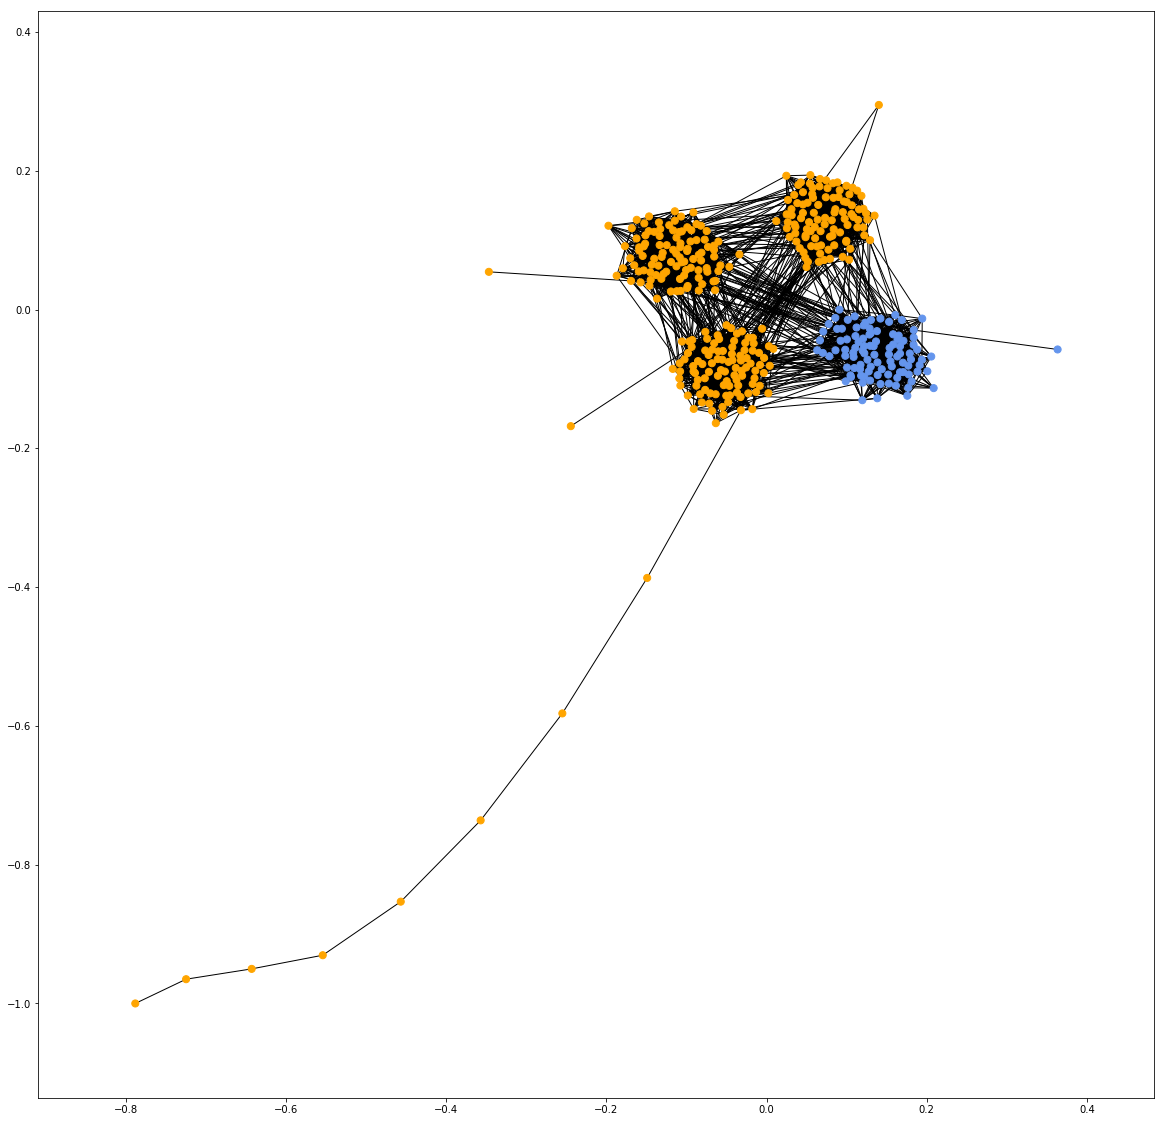

In [137]:
draw_bipartite_graph(train_graph, list(train_graph.nodes()), reg_labels)

In [138]:
# Bechmark the execution time for the computation of eigenvalues for the two matrices
print("Vanilla execution time: {}".format(benchmark(lambda: eig_laplacian(S))))
print("CoreCut execution time: {}".format(benchmark(lambda: eig_laplacian(SR))))

Vanilla execution time: 0.023172974586486816
CoreCut execution time: 0.013750076293945312


## Experiments with more clusters on radom graphs

Graphs with dangling sets

In [139]:
def generate_dangling_random_graph():
    graph = nx.gaussian_random_partition_graph(400, 100, np.inf, 0.4, 0.01)
    graph.add_path([1, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007])
    graph.add_path([150, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007])
    graph.add_path([350, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007])
    return graph

rgraph = generate_dangling_random_graph()
S = nx.to_numpy_matrix(rgraph)
SR = S + (rgraph.number_of_edges() * 2 / np.shape(S)[0]**2)

In [140]:
van_labels = spectral_clust(S, 4)
reg_labels = spectral_clust(SR, 4)

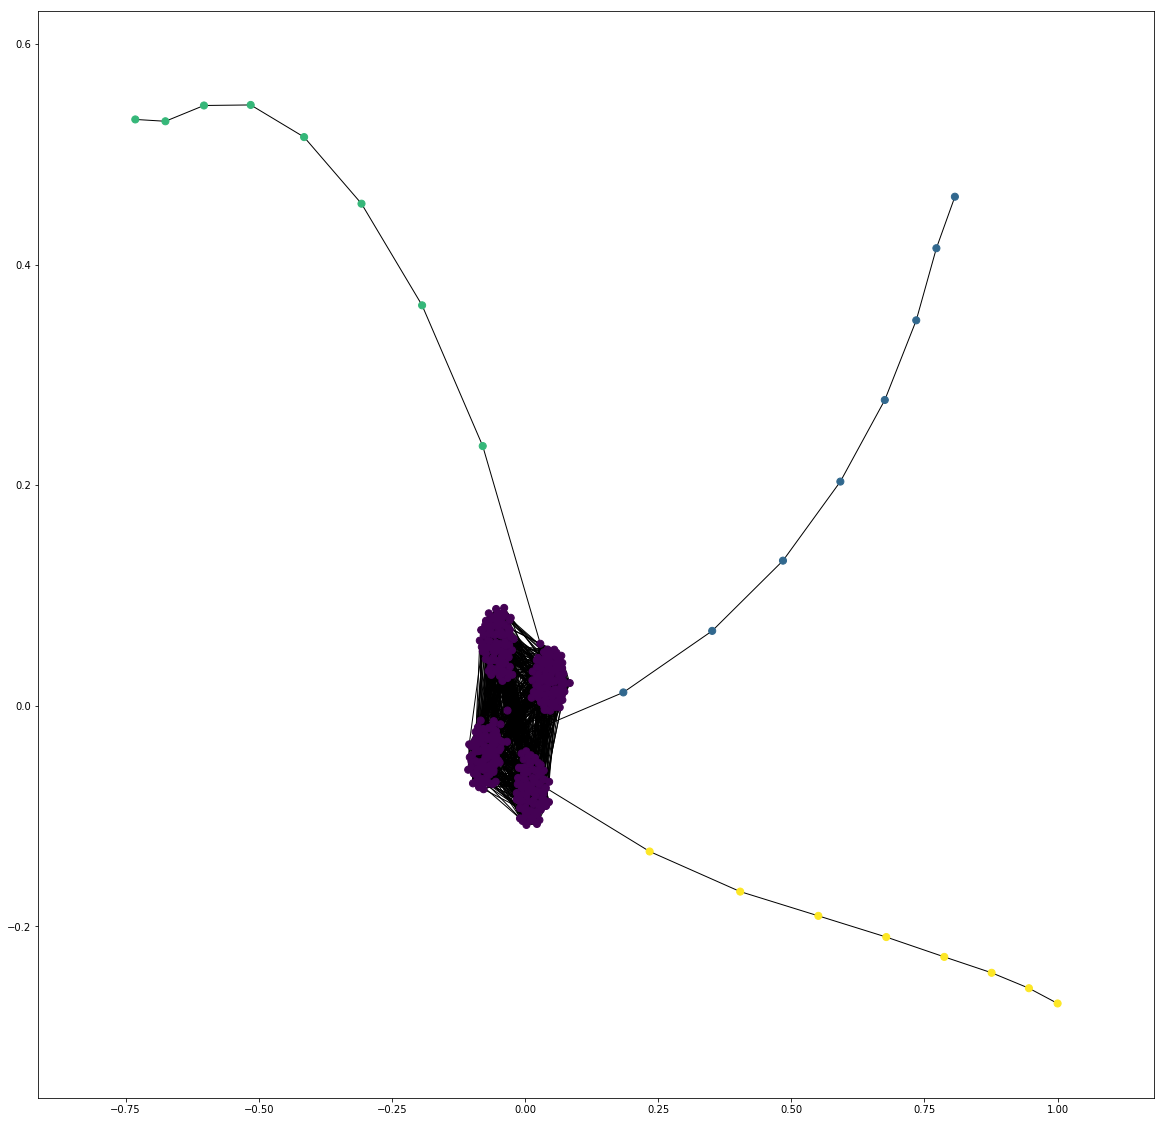

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20));
nx.draw_networkx(rgraph, ax=ax, with_labels=False, nodelist=rgraph.nodes(),
                 node_color=van_labels, node_size=50)

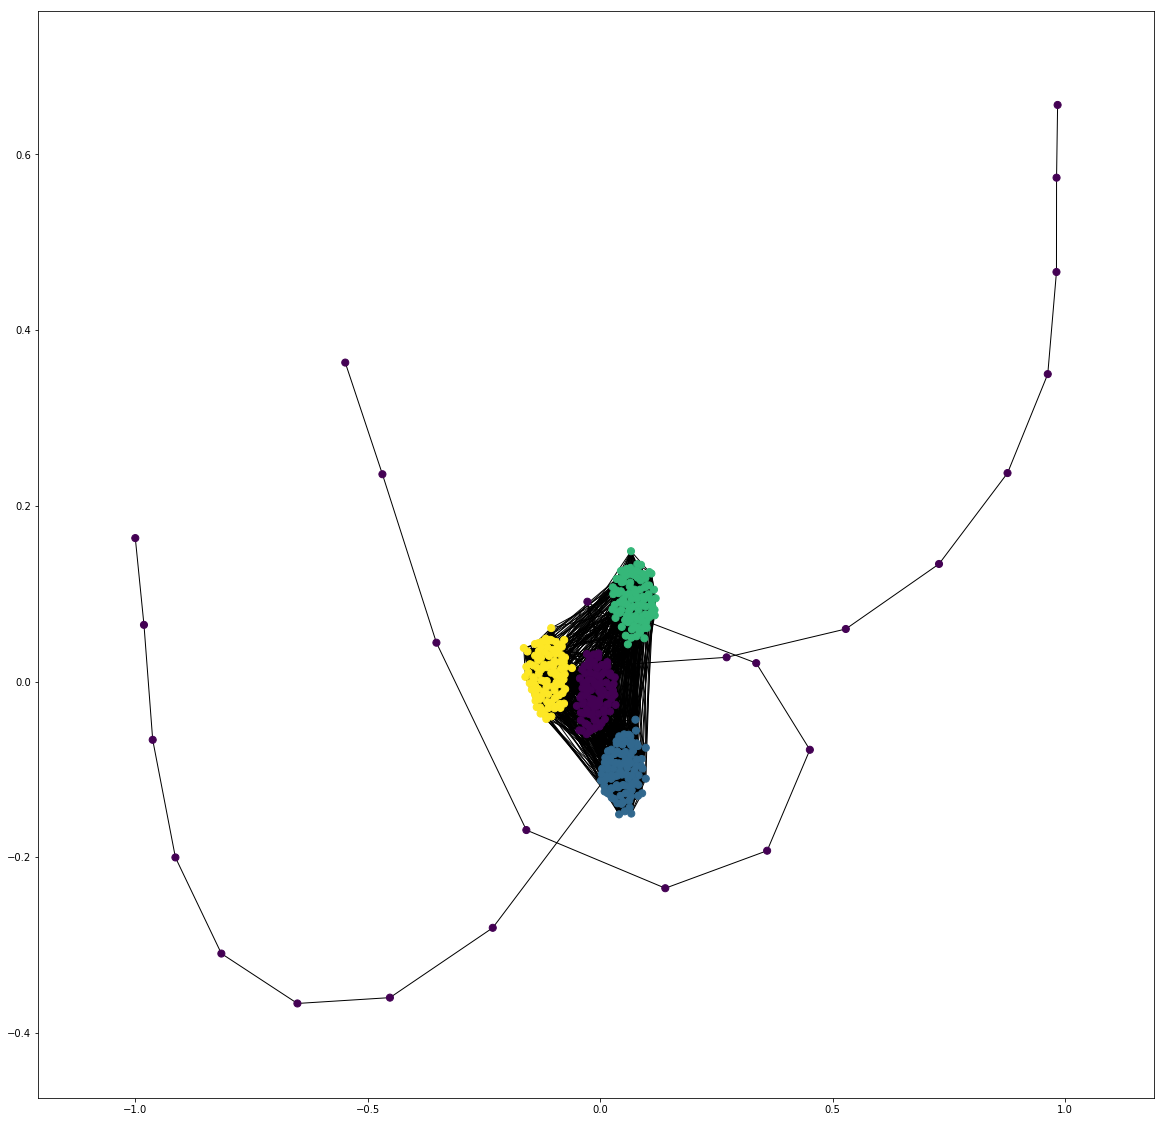

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20));
nx.draw_networkx(rgraph, ax=ax, with_labels=False, nodelist=rgraph.nodes(), node_color=reg_labels, node_size=50)

### Analysing regularisation on graphs with more than 2 clusters

In [214]:
np.random.seed(4)
# train, test = read_graph(graph_map[1])
# train, test = read_graph('', nx.connected_watts_strogatz_graph(2000, 3, p=0.60))
# train, test = read_graph('', nx.barabasi_albert_graph(2000, 3, seed=13))
train, test = read_graph('', nx.powerlaw_cluster_graph(2000, 2, 0.05, seed=13))

tao_heurisitc = 2 * train.number_of_edges() / train.number_of_nodes()
S = nx.to_numpy_matrix(train)

# Tau is initialised with the average degree of the graph
N = train.number_of_nodes()
tao = train.number_of_edges() * 2 / N
SR = S + tao / N

val_van, vec_van = eig_laplacian(S)
val_reg, vec_reg = eig_laplacian(SR)

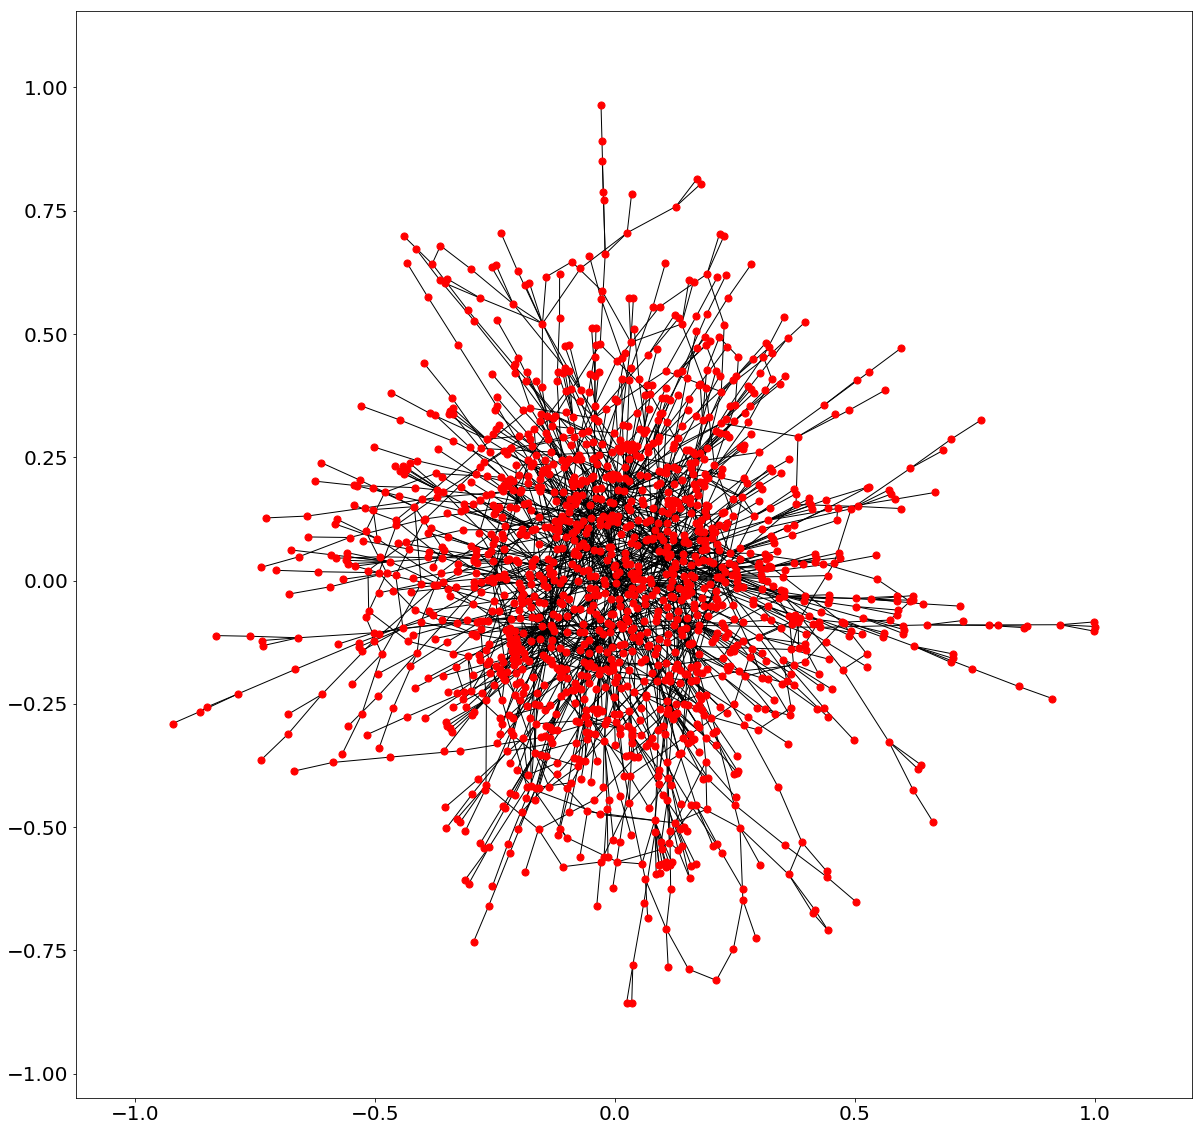

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20));
nx.draw_networkx(train, ax=ax, with_labels=False, nodelist=train.nodes(),node_size=50)

In [216]:
size_std_van, size_std_reg = [], []
def size_std(labels):
    sizes = np.bincount(labels)
    return np.std(sizes)

def avg_conductance(labels, nodes, graph):
    conductances = []
    for label in np.unique(labels):
        partition = np.ravel(nodes[labels == label])
        conductances.append(conductance(graph, partition))
    return np.mean(conductances)
        
clusters = 21
cond_van, cond_reg = [], []
cond_tvan, cond_treg = [], []
nodes = np.array(train.nodes())
for number_of_clusters in range(2, clusters):
    van_labels = spectral_clust(S, number_of_clusters)
    reg_labels = spectral_clust(SR, number_of_clusters)
    
    size_std_van.append(size_std(van_labels))    
    size_std_reg.append(size_std(reg_labels))
    
    cond_van.append(avg_conductance(van_labels, nodes, train))
    cond_reg.append(avg_conductance(reg_labels, nodes, train))   
    
    cond_tvan.append(avg_conductance(van_labels, nodes, test))
    cond_treg.append(avg_conductance(reg_labels, nodes, test))  

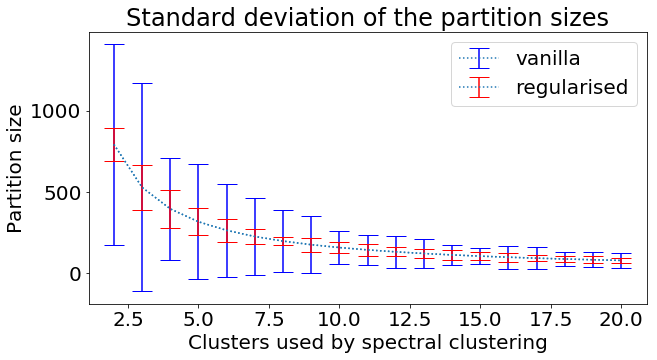

In [217]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mean = N / np.arange(2, clusters)
ax.set_xlabel('Clusters used by spectral clustering')
ax.set_ylabel('Partition size')
ax.set_title('Standard deviation of the partition sizes')
lolims = np.zeros_like(size_std_van)
ax.errorbar(np.arange(2, clusters), mean, yerr=size_std_van, alpha=1, ecolor='blue', capsize=10, lolims=lolims, 
            linestyle='dotted', label='vanilla')
ax.errorbar(np.arange(2, clusters), mean, yerr=size_std_reg, alpha=1, ecolor='red', capsize=10, lolims=lolims, 
            linestyle='dotted', label='regularised')
ax.legend()

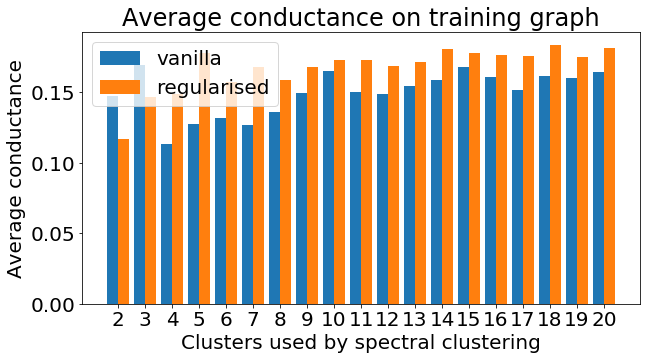

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
w=0.4
ax.set_xlabel('Clusters used by spectral clustering')
ax.set_ylabel('Average conductance')
ax.set_title('Average conductance on training graph')
ax.bar(np.arange(2, clusters)-w, cond_van, width=w, alpha=1, capsize=10, align='edge', label='vanilla')
ax.bar(np.arange(2, clusters), cond_reg, width=w, alpha=1, capsize=10, align='edge', label='regularised')
plt.xticks(np.arange(2, clusters))
ax.legend()

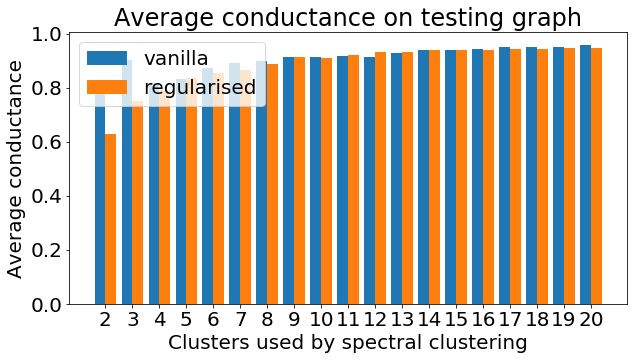

In [219]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
w=0.4
ax.set_xlabel('Clusters used by spectral clustering')
ax.set_ylabel('Average conductance')
ax.set_title('Average conductance on testing graph')
ax.bar(np.arange(2, clusters)-w, cond_tvan, width=w, ecolor='blue', capsize=10, align='edge', label='vanilla')
ax.bar(np.arange(2, clusters), cond_treg, width=w, ecolor='red', capsize=10, align='edge', label='regularised')
plt.xticks(np.arange(2, clusters))
ax.legend()

## The effect of $\tau$ on regularisation

The graph below shows the effects of the regularisation parameter $\tau$ in the size of the minimum partition 

In [220]:
taos = np.exp(np.linspace(-8, 7, 400))
reg_sizes = []
conducts = []
conducts_test = []

nodes = np.array(train.nodes())
for tao in taos:
    SR = S + tao / N
    reg_labels = spectral_clust(SR)   
    
    reg_sizes.append(min(np.sum(reg_labels), N - np.sum(reg_labels)))
    conducts.append(avg_conductance(reg_labels, nodes, train))
    conducts_test.append(avg_conductance(reg_labels, nodes, test))

Text(0,0.5,'Smallest cluster size')

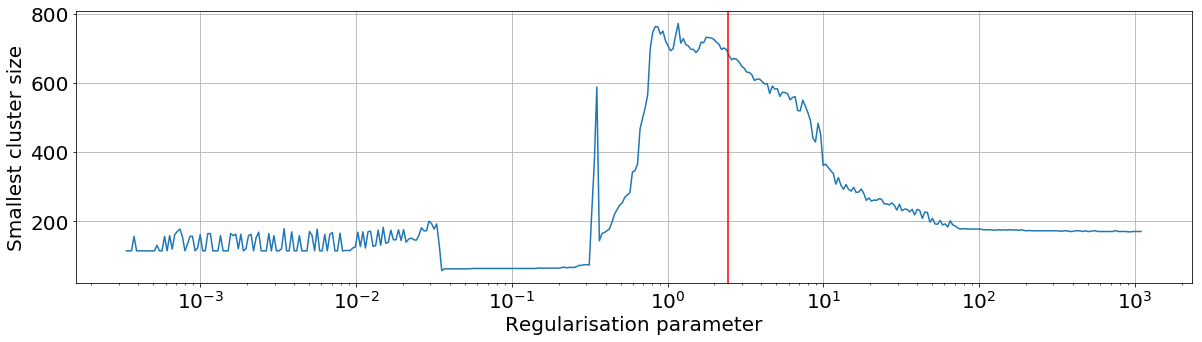

In [221]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(taos, reg_sizes)
ax.grid(True)
ax.axvline(x=(tao_heurisitc), color='red')
ax.set_xscale('log')
ax.set_xlabel('Regularisation parameter')
ax.set_ylabel('Smallest cluster size')

The effect of the $\tau$ on conductance.

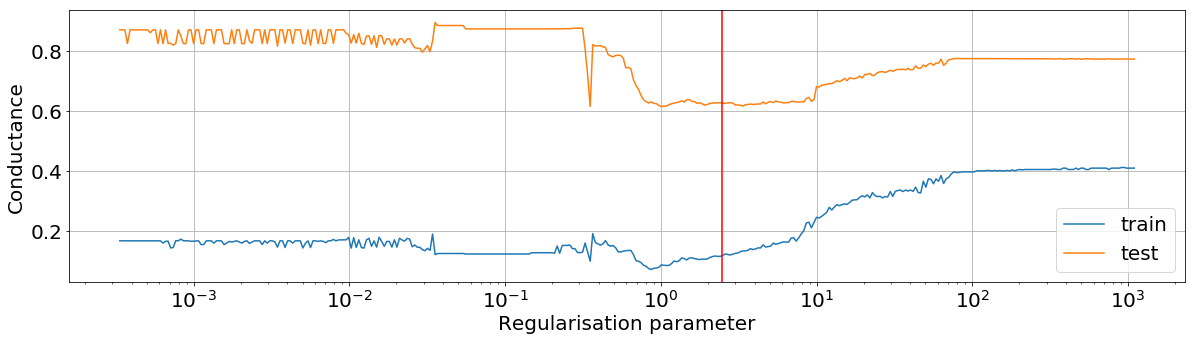

In [222]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_xlabel('Regularisation parameter')
ax.set_ylabel('Conductance')
ax.plot(taos, conducts)
ax.plot(taos, conducts_test)
ax.axvline(x=(tao_heurisitc), color='red')
plt.gca().legend(('train','test'))
ax.set_xscale('log')
ax.grid(True)

## Classifying on email-eu-core

In [244]:
np.random.seed(14)
train, test = read_graph(graph_map[1])
labels = np.loadtxt('./dataset/email-Eu-labels.txt', dtype='int')
labels = np.ravel(labels[:, 1])
S = nx.to_numpy_matrix(train)

In [245]:
from sklearn.metrics import normalized_mutual_info_score

taos = np.exp(np.linspace(-7, 12, 100))
reg_sizes = []
conducts = []
conducts_test = []

N = train.number_of_nodes()
tao_heurisitc = train.number_of_edges() * 2 / N
nodes = np.array(train.nodes())
nmis = []
nmis_ch = []
for tao in taos:
    SR = S + tao / N 
    y_hat = spectral_clust(SR, 42)
    y_hat_ch = spectral_clust_chauduri(S, tao, 42)
    
    nmi = normalized_mutual_info_score(labels[nodes], y_hat)
    nmi_ch = normalized_mutual_info_score(labels[nodes], y_hat_ch)
    nmis.append(nmi)
    nmis_ch.append(nmi_ch)

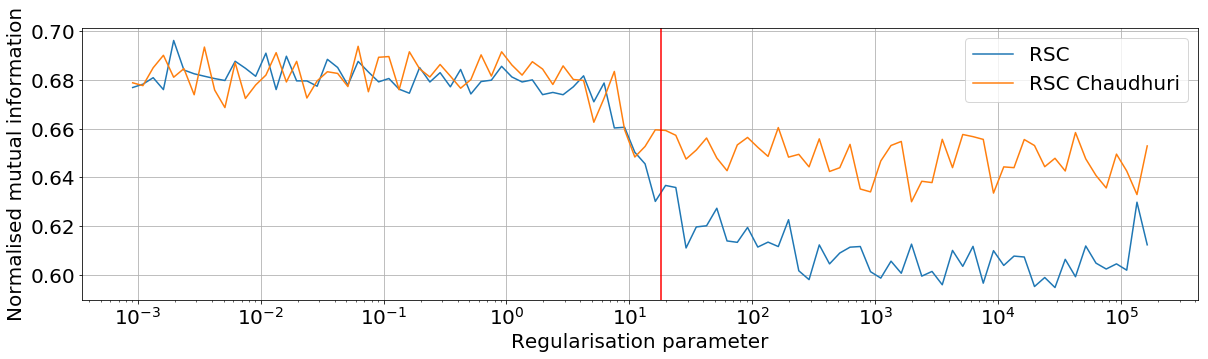

In [246]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(taos, nmis, label='RSC')
ax.plot(taos, nmis_ch, label='RSC Chaudhuri')
ax.grid(True)
ax.axvline(x=(tao_heurisitc), color='red')
ax.set_xscale('log')
ax.set_xlabel('Regularisation parameter')
ax.set_ylabel('Normalised mutual information')
ax.legend()

In [240]:
np.random.seed(7)
N = train.number_of_nodes()
tao_heurisitc = train.number_of_edges() * 2 / N
nodes = np.array(train.nodes())
nmis = []
vnmis = []
SR = S + tao_heurisitc / N 
for c in range(2, 43):
    vy_hat = spectral_clust(S, c)
    y_hat = spectral_clust(SR, c)
    vnmi = normalized_mutual_info_score(labels[nodes], vy_hat)
    nmi = normalized_mutual_info_score(labels[nodes], y_hat)
    nmis.append(nmi)
    vnmis.append(vnmi)

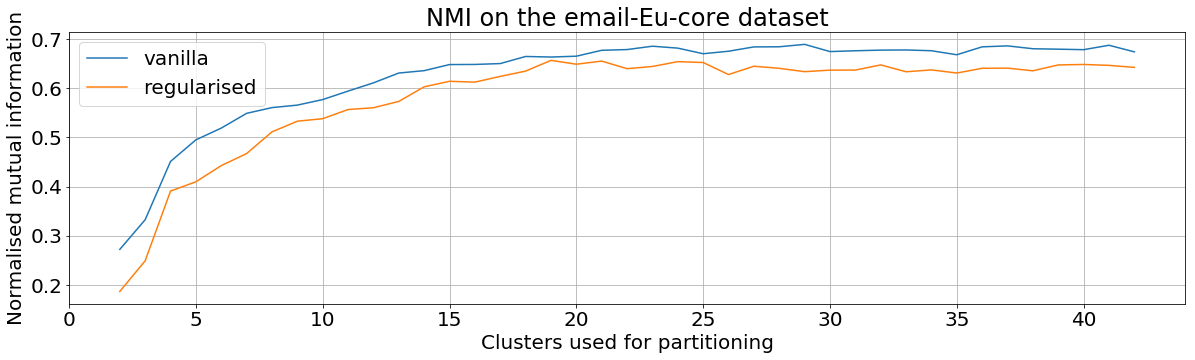

In [241]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(np.arange(2, 43), vnmis, label='vanilla')
ax.plot(np.arange(2, 43), nmis, label='regularised')
ax.grid(True)
ax.set_xlabel('Clusters used for partitioning')
ax.set_title('NMI on the email-Eu-core dataset')
ax.set_ylabel('Normalised mutual information')
ax.legend()

### Analyse regularisation on political network

In [248]:
train = nx.read_gml('./dataset/polblogs.gml').to_undirected()
train = max(nx.connected_component_subgraphs(train), key=len)
S = nx.to_numpy_matrix(train)

# Get the true labels of the political network
true_labels = list(map(lambda node: node[1]['value'], list(train.nodes(data=True))))

In [249]:
# print(train.nodes(data=True))
print(train.number_of_nodes())
print(2 * train.number_of_edges() / train.number_of_nodes())

1222
27.46644844517185


In [250]:
taos = np.exp(np.linspace(-7, 12, 400))
reg_sizes = []
conducts = []
conducts_test = []

N = train.number_of_nodes()
tao_heurisitc = train.number_of_edges() * 2 / N
nodes = np.array(train.nodes())
accuracies = []
accuracies_ch = []
for tao in taos:
    SR = S + tao / N 
    y_hat = spectral_clust(SR)
    y_hat_ch = spectral_clust_chauduri(S, tao)
    
    accuracy = max(np.sum(y_hat == true_labels), np.sum((1 - y_hat) == true_labels)) / N
    accuracy_ch = max(np.sum(y_hat_ch == true_labels), np.sum((1 - y_hat_ch) == true_labels)) / N
    
    accuracies.append(accuracy)
    accuracies_ch.append(accuracy_ch)

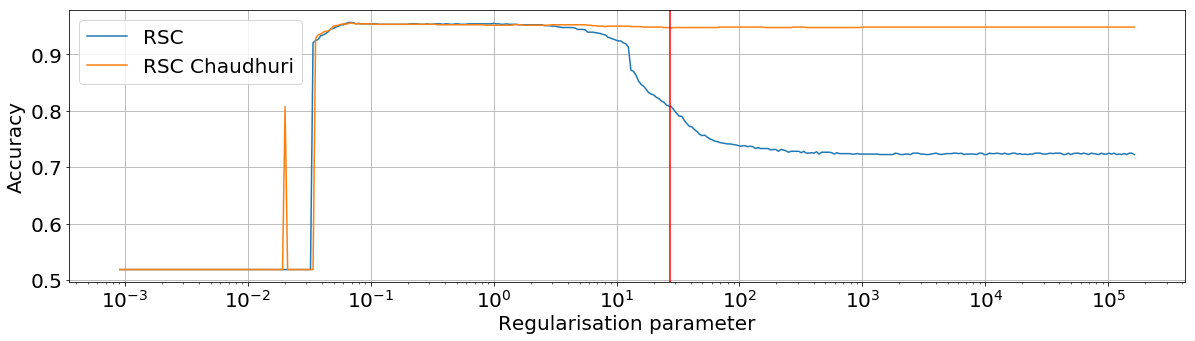

In [251]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(taos, accuracies, label='RSC')
ax.plot(taos, accuracies_ch, label='RSC Chaudhuri')
ax.grid(True)
ax.axvline(x=(tao_heurisitc), color='red')
ax.set_xscale('log')
ax.set_xlabel('Regularisation parameter')
ax.set_ylabel('Accuracy')
ax.legend()